### Please install the required Python modules/SDKs

In [1]:
! activate ai-azure-c1

import sys

sys.path.append("/opt/conda/envs/ai-azure-c1/lib/python3.8/site-packages")

Could not find conda environment: ai-azure-c1
You can list all discoverable environments with `conda info --envs`.



In [2]:
!pip install Pillow==8.4

In [3]:
from PIL import Image
import requests
import glob, os, sys, time, uuid

import matplotlib.pyplot as plt
%matplotlib inline

from io import BytesIO
from PIL import Image, ImageDraw

from azure.cognitiveservices.vision.face import FaceClient
from azure.cognitiveservices.vision.face.models import TrainingStatusType
from msrest.authentication import CognitiveServicesCredentials

### TODO: Accessing Specific Azure Resources

In [4]:
FACE_KEY = "71307f07768144d6a76ee103b05d321d"
FACE_ENDPOINT = "https://nayana-face-api.cognitiveservices.azure.com/"

In [5]:
# Create a client
face_client = FaceClient(FACE_ENDPOINT, CognitiveServicesCredentials(FACE_KEY))
face_client.api_version

'1.0'

### TODO: Upload And View Images
Now, upload several images of your own to this workspace and modify the code below as needed

In [6]:
!ls dwight-wigs/dwight*.jpeg

dwight-wigs/dwight1.jpeg dwight-wigs/dwight4.jpeg dwight-wigs/dwight7.jpeg
dwight-wigs/dwight2.jpeg dwight-wigs/dwight5.jpeg
dwight-wigs/dwight3.jpeg dwight-wigs/dwight6.jpeg


In [7]:
# Get a list of images with file name starting with "human-face"
my_face_images = [file for file in glob.glob('dwight-wigs/dwight*.jpeg')]
print(my_face_images)

['dwight-wigs/dwight7.jpeg', 'dwight-wigs/dwight6.jpeg', 'dwight-wigs/dwight1.jpeg', 'dwight-wigs/dwight3.jpeg', 'dwight-wigs/dwight2.jpeg', 'dwight-wigs/dwight5.jpeg', 'dwight-wigs/dwight4.jpeg']


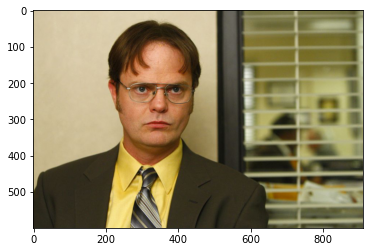

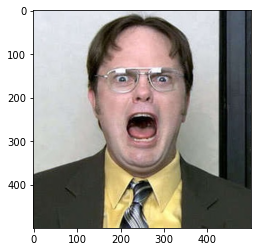

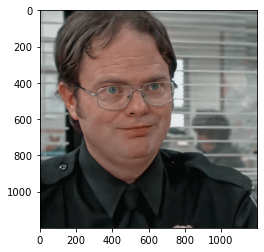

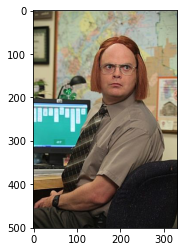

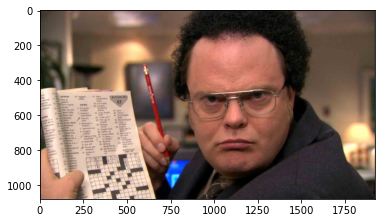

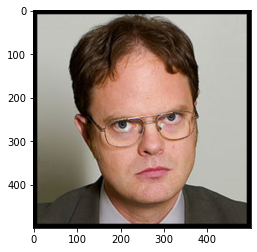

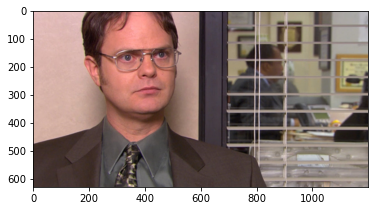

In [8]:
# Plot the images
for img in my_face_images:
    with open(img, 'rb') as img_code:
        img_view_ready = Image.open(img_code)
        plt.figure()
        plt.imshow(img_view_ready)

### TODO: Creating Person Model

In [9]:
PERSON_GROUP_ID = str(uuid.uuid4())
person_group_name = 'dwight-schrute'

In [10]:
# Todo: define a function to create and train a person group
def build_person_group(client, person_group_id, pgp_name):
    print('Create and build a person group...')
    # Create empty Person Group. Person Group ID must be lower case, alphanumeric, and/or with '-', '_'.
    print('Person group ID:', person_group_id)
    
    # Todo: create a person group using the person_group.create object
    client.person_group.create(person_group_id=person_group_id, name=person_group_id)

    # Todo: create a person group person using the person_group_person.create object
    my_face = client.person_group_person.create(person_group_id, pgp_name)
    
    # Find all jpeg images of human in working directory.
    my_face_images = [file for file in glob.glob('dwight-wigs/dwight*.jpeg')]
    
    # Add images to a Person object
    for image_p in my_face_images:
        with open(image_p, 'rb') as w:
            client.person_group_person.add_face_from_stream(person_group_id, my_face.person_id, w)

    # Todo: train the person group using the person_group.train object
    client.person_group.train(person_group_id)

    # Wait for training to finish.
    while (True):
        training_status = client.person_group.get_training_status(person_group_id)
        print("Training status: {}.".format(training_status.status))
        if (training_status.status is TrainingStatusType.succeeded):
            break
        elif (training_status.status is TrainingStatusType.failed):
            client.person_group.delete(person_group_id=PERSON_GROUP_ID)
            sys.exit('Training the person group has failed.')
        time.sleep(5)

In [11]:
build_person_group(face_client, PERSON_GROUP_ID, person_group_name)

Create and build a person group...
Person group ID: 94961bb4-c83d-4e17-88dc-21b6fa6399b9
Training status: running.
Training status: succeeded.


### TODO: Making Sure The Faces In The Person Model Belong To The Same Person

In [12]:
# Todo: detect all faces in query_image_list, then add their face IDs to a new list.
def detect_faces(client, query_images_list):
    print('Detecting faces in query images list...')

    face_ids = {} # Keep track of the image ID and the related image in a dictionary
    for image_name in query_images_list:
        image = open(image_name, 'rb') # BufferedReader
        print("Opening image: ", image.name)
        time.sleep(5)

        # Todo: detect the faces in the query images list using face.detect_with_stream object
        faces = client.face.detect_with_stream(image)

        # Add all detected face IDs to a list
        for face in faces:
            print('Face ID', face.face_id, 'found in image', os.path.splitext(image.name)[0]+'.jpeg')
            # Add the ID to a dictionary with image name as a key.
            # This assumes there is only one face per image (since you can't have duplicate keys)
            face_ids[image.name] = face.face_id

    return face_ids

In [13]:
# Detect faces in the test images
ids = detect_faces(face_client, my_face_images)
ids

Detecting faces in query images list...
Opening image:  dwight-wigs/dwight7.jpeg
Face ID 9ab11ea6-4bb2-457e-905a-b3cbac4e8667 found in image dwight-wigs/dwight7.jpeg
Opening image:  dwight-wigs/dwight6.jpeg
Face ID 34923e51-8f36-4f9d-8911-fe3f1ceba639 found in image dwight-wigs/dwight6.jpeg
Opening image:  dwight-wigs/dwight1.jpeg
Face ID eef5389b-01b0-46c9-bc48-6c177d651d1c found in image dwight-wigs/dwight1.jpeg
Opening image:  dwight-wigs/dwight3.jpeg
Face ID 514afbe1-b5ac-46e1-b974-30c4b1a79681 found in image dwight-wigs/dwight3.jpeg
Opening image:  dwight-wigs/dwight2.jpeg
Face ID 58fc20b3-df63-4ec7-9d57-2b8397bf73cc found in image dwight-wigs/dwight2.jpeg
Opening image:  dwight-wigs/dwight5.jpeg
Face ID 5ad3bfd8-cd54-45e2-a9f4-539d16df846a found in image dwight-wigs/dwight5.jpeg
Opening image:  dwight-wigs/dwight4.jpeg
Face ID 5a933a37-783d-49d3-9322-cbea800993e2 found in image dwight-wigs/dwight4.jpeg


{'dwight-wigs/dwight7.jpeg': '9ab11ea6-4bb2-457e-905a-b3cbac4e8667',
 'dwight-wigs/dwight6.jpeg': '34923e51-8f36-4f9d-8911-fe3f1ceba639',
 'dwight-wigs/dwight1.jpeg': 'eef5389b-01b0-46c9-bc48-6c177d651d1c',
 'dwight-wigs/dwight3.jpeg': '514afbe1-b5ac-46e1-b974-30c4b1a79681',
 'dwight-wigs/dwight2.jpeg': '58fc20b3-df63-4ec7-9d57-2b8397bf73cc',
 'dwight-wigs/dwight5.jpeg': '5ad3bfd8-cd54-45e2-a9f4-539d16df846a',
 'dwight-wigs/dwight4.jpeg': '5a933a37-783d-49d3-9322-cbea800993e2'}

### TODO: Verify that 2 random images from the list belong to the same person

In [14]:
# Todo: use face.verify_face_to_face object to verify that 2 random faces from the list belong to the same person
verify_result = face_client.face.verify_face_to_face(ids['dwight-wigs/dwight5.jpeg'], ids['dwight-wigs/dwight3.jpeg'])

In [15]:
if verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.72698.


### TODO: Prepare An Image For Facial Recognition

In [16]:
# Todo: Replace with your own image URL. This image will be used to perform facial recognition
dl_source_url = "https://cdn.nametagwizard.com/media/catalog/product/o/f/officepid_4.png"

In [17]:
# Todo: detect the face in the image using face.detect_with_url object
dl_faces = face_client.face.detect_with_url(dl_source_url) 

In [18]:
## -------
## Reading file locally
## -------
# If you uploaded an image file locally, you should use the following method to detect the face
# dl_image = open('/your-local-file-system/udacity/cal-dl.png', 'rb')
# dl_faces = face_client.face.detect_with_stream(dl_image)  

In [19]:
# View Face ID and then save it into the list of already saved Face IDs
for idx, face in enumerate(dl_faces):
    print('Face ID', face.face_id, 'found in image', dl_source_url)
    # Add the ID to a dictionary with image name as a key.
    # This assumes there is only one face per image (since you can't have duplicate keys)
    ids["sample-image.png"] = face.face_id

Face ID 5ac04868-e0d2-482f-be1e-0e655ebf1eed found in image https://cdn.nametagwizard.com/media/catalog/product/o/f/officepid_4.png


In [20]:
# Now, you should have (n + 1) Face IDs in your Face ID list
ids

{'dwight-wigs/dwight7.jpeg': '9ab11ea6-4bb2-457e-905a-b3cbac4e8667',
 'dwight-wigs/dwight6.jpeg': '34923e51-8f36-4f9d-8911-fe3f1ceba639',
 'dwight-wigs/dwight1.jpeg': 'eef5389b-01b0-46c9-bc48-6c177d651d1c',
 'dwight-wigs/dwight3.jpeg': '514afbe1-b5ac-46e1-b974-30c4b1a79681',
 'dwight-wigs/dwight2.jpeg': '58fc20b3-df63-4ec7-9d57-2b8397bf73cc',
 'dwight-wigs/dwight5.jpeg': '5ad3bfd8-cd54-45e2-a9f4-539d16df846a',
 'dwight-wigs/dwight4.jpeg': '5a933a37-783d-49d3-9322-cbea800993e2',
 'sample-image.png': '5ac04868-e0d2-482f-be1e-0e655ebf1eed'}

### TODO: Perform Face Verification Between One Of The Face In The Person Model And The Sample Image Face

In [23]:
# Todo: use face.verify_face_to_face to verify that the faces belong to the same person.
# Make sure you verify between the sample image and one of the image in the person model
dl_verify_result = face_client.face.verify_face_to_face(ids['dwight-wigs/dwight5.jpeg'], ids['sample-image.png'])

In [24]:
if dl_verify_result.is_identical:
    print("Faces are of the same (Positive) person, similarity confidence: {}.".format(verify_result.confidence))
else:
    print("Faces are of different (Negative) persons, similarity confidence: {}.".format(verify_result.confidence))

Faces are of the same (Positive) person, similarity confidence: 0.72698.


In [25]:
# Convert width height to a point in a rectangle
def getRectangle(faceDictionary):
    rect = faceDictionary.face_rectangle
    left = rect.left
    top = rect.top
    right = left + rect.width
    bottom = top + rect.height
    
    return ((left, top), (right, bottom))

# Draw boxes around every detected faces
def drawFaceRectangles(source_file, detected_face_object) :
    # Download the image from the url
    response = requests.get(source_file)
    img = Image.open(BytesIO(response.content))
    # Draw a red box around every detected faces
    draw = ImageDraw.Draw(img)
    for face in detected_face_object:
        draw.rectangle(getRectangle(face), outline='red', width = 10)
    return img

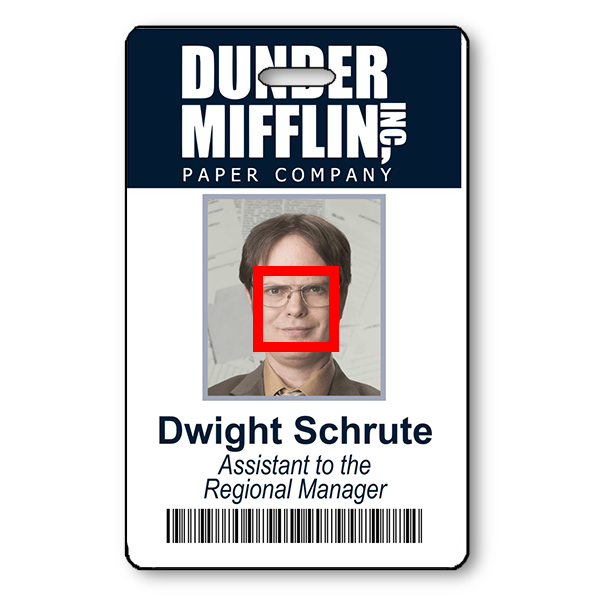

In [26]:
drawFaceRectangles(dl_source_url, dl_faces)

### TODO: Identify The Sample Image with The Person Model 

In [31]:
# Todo: enter the face ID of the sample image
get_the_face_id_from_the_driving_license = '5ac04868-e0d2-482f-be1e-0e655ebf1eed'

In [32]:
# Todo: identify the sample image using the face.identify object
person_gp_results = face_client.face.identify([get_the_face_id_from_the_driving_license], PERSON_GROUP_ID)

In [33]:
for result in person_gp_results:
    for candidate in result.candidates:
        print("The Identity match confidence is {}".format(candidate.confidence))

The Identity match confidence is 0.85434
